### SOM Algorithm

1) Start with a dataset of n_featurs independent variables

2) Create a grid composed of nodes, each one with a weight vector of n_features

3) Randomly initialize the values of weight vectors to small numbers close to 0 but not 0

4) Select one random observation point from the dataset

5) Compute Euclidean distances from this point to the different neurons in the network

6) Winning node = node with minimum distance from our selected point.

7) Update weights of the winning node to move it closer to the point.

8) Using a Gaussian neighborhood function, update the weights of the winning node neighbors to move them closer to the point. The neighborhood radius is the sigma in the Gaussian function.

9) Repeat steps 1-5 and update the weights after each observation (reinforcement learning) or after a batch of observations (batch learning) until the network converges to a point where the neighborhood stops decreasing.

In [1]:
!pip install MiniSom

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing dataset

In [3]:
# From UCI ML Repo
# Statlog (Australian Credit Approval) Dataset
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

### Feature Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

### Training the SOM

In [5]:
from minisom import MiniSom
som = MiniSom(x = 10, # length dimension of grid
              y = 10, # width dimension of grid
              input_len = 15, # number of features in X
              sigma = 1.0, # radius of neighborhoods in grid
              learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

### Visualizing the map

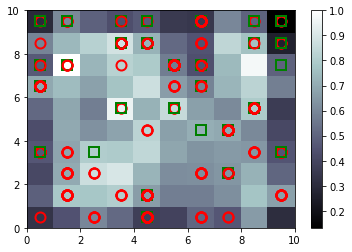

In [6]:
from pylab import bone, pcolor, colorbar, plot, show
bone() # initialize an empty window
pcolor(som.distance_map().T) # obtain colors corresponding to Mean Interneuron Distances
colorbar() # gives us axes to represent range of color values
markers = ['o', 's'] # markers to distinguish approval vs. rejection
colors = ['r', 'g'] # colors for our markers

# i will index all our customers
# x will enumerate the vectors corresponding to each customer
for i, x in enumerate(X):
    w = som.winner(x) # obtain winning node for customer x
    # (w[0], w[1]) = xy coordinate of lower left corner of winning node
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

### Idenitfying frauding customers

In [8]:
mappings = som.win_map(X)
# From our map the coordinates of the likely frauds are
# (4, 1) and (5, 3) looking at the lower left corner
frauds = np.concatenate((mappings[(1,7)], mappings[(3,5)]), axis = 0)
frauds = sc.inverse_transform(frauds)

In [9]:
print('Likely Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Likely Fraud Customer IDs
15687688
15638610
15789611
15668679
15738487
15649160
15773421
15682686
15781875
15809837
15621244
15636521
15632789
15761554
15707602
15811690
15815095
15720725
15567834
15591035
15672912
15694677
15598614
15772941
15646190
15608804
15631267
15611189
15759387
15712483
15572361
15698522
15790254
15768600
15748552
15757467
15682576
15642391
15801441
15815443
15748432
15708714
15788131
15635244
15699963
15771856
15648876
15679394
15720644
15696287
15808023
15795079
15808386
15698749
15746258
15764841
15748649
15729718
15786539
15773776
15778345
15791769
15629133
15667588
15776494


### Using an Artifical Neural Network

In [11]:
customers = dataset.iloc[:, 1:].values

In [12]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if (dataset.iloc[i, 0] in frauds):
        is_fraud[i] = 1

In [13]:
from sklearn.preprocessing import StandardScaler
sc_2 = StandardScaler()
customers = sc.fit_transform(customers)

In [18]:
from keras.models import Sequential
from keras.layers import Dense

In [19]:
ann_model = Sequential()
ann_model.add(Dense(units = 2, activation = "relu"))
ann_model.add(Dense(units = 1, activation = "sigmoid"))
ann_model.compile(optimizer = "adam",
                 loss = "binary_crossentropy",
                 metrics = ["accuracy"])

In [20]:
ann_model.fit(x = customers, 
              y = is_fraud, 
              batch_size = 1, 
              epochs = 15)

Epoch 1/15
690/690 [==============================] - 1s 1ms/step - loss: 0.4325 - accuracy: 0.8594
Epoch 2/15
690/690 [==============================] - 1s 1ms/step - loss: 0.2966 - accuracy: 0.9058
Epoch 3/15
690/690 [==============================] - 1s 1ms/step - loss: 0.2369 - accuracy: 0.9058
Epoch 4/15
690/690 [==============================] - 1s 2ms/step - loss: 0.1848 - accuracy: 0.9043
Epoch 5/15
690/690 [==============================] - 1s 1ms/step - loss: 0.1472 - accuracy: 0.9362
Epoch 6/15
690/690 [==============================] - 1s 1ms/step - loss: 0.1225 - accuracy: 0.9565
Epoch 7/15
690/690 [==============================] - 1s 1ms/step - loss: 0.1057 - accuracy: 0.9739
Epoch 8/15
690/690 [==============================] - 1s 1ms/step - loss: 0.0939 - accuracy: 0.9754
Epoch 9/15
690/690 [==============================] - 1s 1ms/step - loss: 0.0848 - accuracy: 0.9725
Epoch 10/15
690/690 [==============================] - 1s 1ms/step - loss: 0.0785 - accuracy: 0.9768

### Predicting test set results

In [21]:
y_pred = ann_model.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[: 1].argsort()]
print(y_pred)

[[[1.57395480e+07 3.62393260e-03]
  [1.57761560e+07 3.63445247e-06]]]
